In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from typing_extensions import Literal
from IPython.display import clear_output
from tqdm.notebook import tqdm

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128

In [ ]:
import albumentations as A
import albumentations.pytorch


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transforms):
        self.images = glob.glob(image_path)
        self.transforms = transforms

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert("L"))
        img = img[130:430, 100:400]
        augmentations = self.transforms(image=img)
        image = augmentations["image"]
        return image

    def __len__(self):
        return len(self.images)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/Screens.zip .

In [ ]:
!unzip -q Screens.zip -d Screens
!rm -rf Screens.zip

In [ ]:
data = SegmentationDataset(
    image_path="Screens/Screens/*/*.png",
    transforms=A.Compose([A.Resize(height=128, width=128),A.Normalize((0.5,), (0.5,)), A.pytorch.transforms.ToTensorV2()]),
)

#train_loader = torch.utils.data.DataLoader(
#    dataset=data, batch_size=BATCH_SIZE, pin_memory=True, num_workers=3
#)

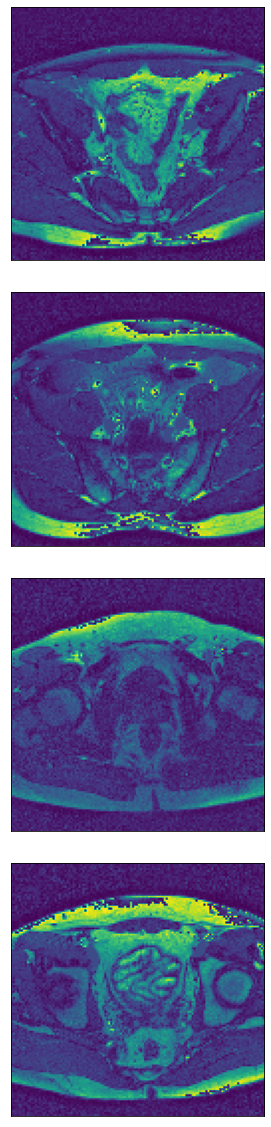

In [ ]:
def im_show(img_list) -> None:
    """
    Plots images with correspinding segmentation mask

    :param img_list: list of paths to images
    """
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    fig, axes = plt.subplots(len(img_list), 1, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx].imshow(np.array(to_PIL(sample)))
        for ax in axes:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


img_list = []
for i in range(4):
    img = data[i]
    img_list.append(img)

im_show(img_list)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3),
            nn.Conv2d(10, 20, kernel_size=3, stride = 2),
            nn.Flatten(),
            nn.Linear(20*62*62, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img #.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
discr_loss_trace = []
gen_loss_trace = []

## 1. Vanilla GAN: двумерные данные

Для Vanilla GAN функционал имеет следующий вид:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X_real):

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        i = 0
        for epoch in tqdm(range(self.n_epochs)):
            print('Epoch', epoch)
            for real_batch in DataLoader(X_real, batch_size=self.batch_size, shuffle=True):
                ### YOUR CODE IS HERE ######
                real_objects = real_batch
                real_objects = real_objects.to(DEVICE)
                
                num_objects = real_objects.shape[0]
                z = torch.normal(0, 1, (len(real_objects), self.latent_dim))
                gen_objects = self.generator(z)
                
                real_objects_scores = self.discriminator(real_objects)
                gen_objects_scores = self.discriminator(gen_objects)
                
                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                if i % (self.n_critic + 1) == 0:
                    self.opt_gen.zero_grad()
                    #gen_loss = gan_loss(
                    #    real_objects_scores, gen_objects_scores, "generator"
                    #)
                    valid = torch.ones(real_objects.size(0), 1)
                    
                    gen_loss = F.binary_cross_entropy(self.discriminator(self.generator(z)), valid)
                    gen_loss.backward()
                    self.opt_gen.step()
                    gen_loss_trace.append(gen_loss.item())
                else:
                    self.opt_disc.zero_grad()
                    #discr_loss = gan_loss(
                    #    real_objects_scores, gen_objects_scores, "discriminator"
                    #)
                    valid = torch.ones(real_objects.size(0), 1)
                    real_loss = F.binary_cross_entropy(self.discriminator(real_objects), valid)
                    fake = torch.zeros(real_objects.size(0), 1)
                    fake_loss = F.binary_cross_entropy(self.discriminator(self.generator(z).detach()), fake)
                    discr_loss = (real_loss + fake_loss) / 2
                    discr_loss.backward()
                    self.opt_disc.step()
                    discr_loss_trace.append(discr_loss.item())
                i += 1


            # caiculate and store loss after an epoch
            #Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            #X_fake = self.generator(Z_noise)
            #loss_epoch = torch.mean(self.discriminator(X_real)) - torch.mean(
             #   self.discriminator(X_fake)
            #)
            #self.loss_history.append(loss_epoch.detach().cpu())
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

In [ ]:
latent_dim = 100
data_shape = (1, 128, 128)
generator = Generator(latent_dim=latent_dim, img_shape=data_shape)
discriminator = Discriminator(img_shape=data_shape)

fitter = Fitter(
    generator,
    discriminator,
    batch_size=128,
    n_epochs=1000,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(data)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


KeyboardInterrupt: ignored

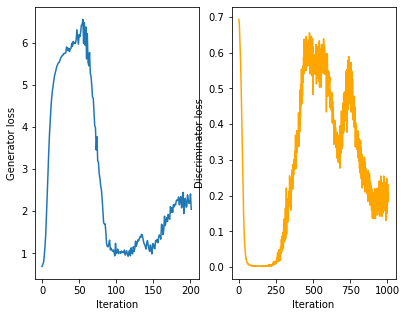

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.xlabel("Iteration")
plt.ylabel("Generator loss")
plt.plot(range(len(gen_loss_trace)), gen_loss_trace)

plt.subplot(1, 3, 2)
plt.xlabel("Iteration")
plt.ylabel("Discriminator loss")
plt.plot(range(len(discr_loss_trace)), discr_loss_trace, color="orange")

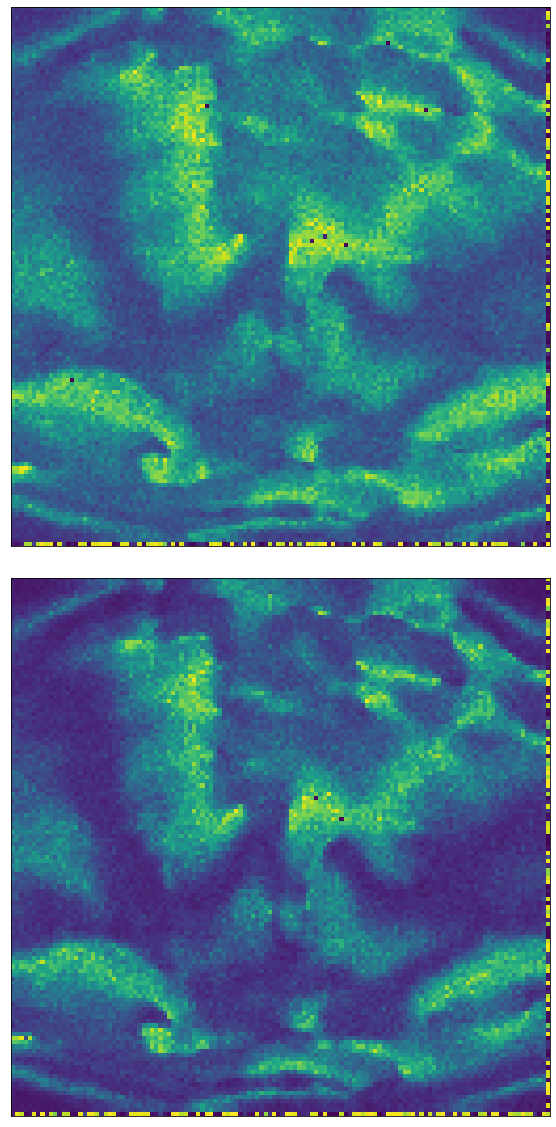

In [ ]:
z = torch.normal(0, 1, (2, 100))
images = generator(z)
im_show(images)

In [ ]:
discr_loss_trace[-1]

0.23050972819328308